# Recommender System Group Project

**Course:** 

INFO345 — Research Topics in Recommender Systems

**Overview:**

This Jupyter notebook implements a complete offline evaluation pipeline for several recommendation approaches, based on curated Steam game interaction data.

**The following methods are implemented:**
- Data loading & preprocessing.
- Exploratory Data Analysis (EDA).
- Item–Item Collaborative Filtering (CF) (cosine similarity).
- User–User Collaborative Filtering (memory-safe approximation).
- Content-Based Filtering (CBF) using SteamSpy tag features (based on the dataset from Kaggle: Nik Davis, Steam Store Games).
- Baseline recommenders: Popularity & Random.
- Offline evaluation: Precision@K and Recall@K.
- Result comparison, observations, and reproducibility notes.

**References for code in this notebook:**
- Jannach, D., & Zanker, M. - Reccomender Systems: An Introduction.
- INFO345 Lectures, 1 - 9.
- Steam databases from Kaggle:
    - steam-store-games by Nik Davis.
    - steam-video-games by tamber.
- SteamSpy tag metadata (for CBF implementation).

**Reproducibility Notes**

To rerun the entire workflow:

**1. Place required data files into `../data/`**
- `steam_reviews_trimmed.csv`  
- `steamspy_tag_data.csv`

**2. Install required Python packages**

pip install -r requirements.txt

**3. Execute the notebook**
- Restart the kernel if needed.
- Run all cells from top to bottom.
- Ensure data paths in the first cell match your directory structure. This guarantees that all variables (e.g., train_matrix, test_matrix, tag embeddings) are defined in the correct order.

## 1. Imports and Path Setup

In this section we load all required Python libraries and define the paths to the datasets used throughout the notebook.

The analysis uses:

- pandas / numpy for data handling  
- scikit-learn for similarity computation  
- matplotlib for basic visualizations  

We also fix a random seed to ensure reproducible results.

In [1]:
# Imports and paths
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

np.random.seed(42)

# Paths (relative to notebook location)
DATA_PATH = '../data/steam_reviews_trimmed.csv'
TAG_PATH = '../data/steamspy_tag_data.csv'

print('DATA_PATH =', DATA_PATH)
print('TAG_PATH =', TAG_PATH)


DATA_PATH = ../data/steam_reviews_trimmed.csv
TAG_PATH = ../data/steamspy_tag_data.csv


## 2. Load Review Dataset

We now load the main Steam reviews dataset.
  
This dataset contains user–item interactions with a `recommended` field that we convert into implicit binary feedback:

- `1` = user recommended the game.
- `0` = user did not recommend.

We also perform a few safety checks to ensure that the dataset exists and that the rating column is correctly initialized.

In [ ]:
# Load dataset
assert os.path.exists(DATA_PATH), f"Dataset not found at: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
# convert recommended to binary implicit rating
if 'recommended' in df.columns:
    df['rating'] = df['recommended'].astype(int)
else:
    # fallback if already binary
    df['rating'] = df.get('rating', 1)

print('Rows:', len(df))
print(df.columns.tolist())
df.head()


Rows: 1670727
['app_id', 'app_name', 'recommended', 'author.steamid', 'rating']


,app_id,app_name,recommended,author.steamid,rating
0,292030,The Witcher 3: Wild Hunt,True,76561198020027165,1
1,292030,The Witcher 3: Wild Hunt,True,76561198316530785,1
2,292030,The Witcher 3: Wild Hunt,True,76561198246626952,1
3,292030,The Witcher 3: Wild Hunt,True,76561198220195440,1
4,292030,The Witcher 3: Wild Hunt,True,76561198983515611,1


## 3. Exploratory Data Analysis (EDA)

Before building any recommender model, we examine the structure of the dataset:

- Number of unique users.
- Number of unique games. 
- Proportion of positive (recommended) interactions.
- Most frequently reviewed games.

These basic statistics help us understand dataset sparsity and interaction distribution, which influence model performance.

In [3]:
# Basic EDA
print('Unique users:', df['author.steamid'].nunique())
print('Unique items:', df['app_id'].nunique())
print('Positive (recommended) fraction:', df['rating'].mean())

print('\nTop 10 games by #reviews:')
print(df['app_name'].value_counts().head(10))


Unique users: 117263
Unique items: 313
Positive (recommended) fraction: 0.85504274486496

Top 10 games by #reviews:
app_name
Grand Theft Auto V                44825
PLAYERUNKNOWN'S BATTLEGROUNDS     38515
Tom Clancy's Rainbow Six Siege    36383
The Witcher 3: Wild Hunt          34870
PAYDAY 2                          31781
Garry's Mod                       30468
Terraria                          28807
Fallout 4                         27726
DARK SOULS™ III                   23653
The Elder Scrolls V: Skyrim       23110
Name: count, dtype: int64


## 4. Train/Test Split (Implicit Feedback)

We now prepare the interaction matrix used by all recommenders. Each record represents an implicit interaction:

- `user_id` = Steam user.
- `item_id` = game.
- `rating` = binary (1 = recommended, 0 = not recommended).

Before splitting:

- We rename columns for consistency.
- We remove duplicate `(user, item)` pairs to avoid data leakage.
- A standard 90/10 train–test split is used.

The test set is later used for all evaluation metrics (Precision@K, Recall@K).

In [4]:
# Prepare ratings and perform train/test split
ratings = df.rename(columns={'author.steamid':'user_id', 'app_id':'item_id'})[['user_id','item_id','rating']]

# Drop exact duplicate interactions (user,item) prior to split
ratings = ratings.drop_duplicates(subset=['user_id','item_id'], keep='first')

train_df, test_df = train_test_split(ratings, test_size=0.1, random_state=42)
print('Train size:', len(train_df))
print('Test size:', len(test_df))


Train size: 1494135
Test size: 166015


## 5. Constructing the User–Item Matrix (Train Only)

We now convert the training interactions into a user–item matrix:

- Rows = users.
- Columns = games.
- Values = implicit binary ratings (0/1).

Missing interactions are treated as 0 (implicit “no interaction”).

For item–item collaborative filtering, we transpose the matrix to obtain:

- Rows = items.
- Columns = users.

We then compute a cosine similarity matrix between items. This similarity matrix will later be used to generate item-based CF recommendations.

In [5]:
# Build user-item train matrix
train_matrix = train_df.pivot_table(index='user_id', columns='item_id', values='rating', aggfunc='mean').fillna(0)

# transpose to items x users
item_matrix_train = train_matrix.T

# item-item similarity (cosine)
item_sim_matrix_train = cosine_similarity(item_matrix_train)
item_sim_train = pd.DataFrame(item_sim_matrix_train, index=item_matrix_train.index, columns=item_matrix_train.index)

print('train_matrix shape:', train_matrix.shape)
print('item_sim_train shape:', item_sim_train.shape)


train_matrix shape: (117263, 313)
item_sim_train shape: (313, 313)


## 6. Item–Item Collaborative Filtering (Memory-Efficient, Explainable)

We now implement a simple item–item collaborative filtering (CF) recommender.

**How it works:**

For a given user:
1. Identify the items they have interacted with (`liked_items`).
2. For each liked item, retrieve its similarity scores to all other items.
3. Sum these similarity vectors to compute a global preference score.
4. Recommend the highest-scoring items that the user has not already interacted with.

**Why this method?**

- Easy to explain ("recommended because you liked X").
- Efficient: cosine similarities were precomputed in the previous step.
- Works well for implicit feedback datasets like Steam reviews.

We also add a heatmap for use in the report.

Sample user: 76561197960269230
CF recs: [379720, 620, 72850, 105600, 271590]


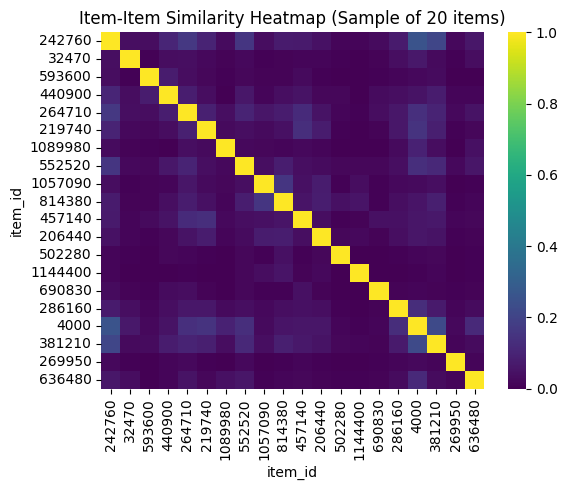

In [ ]:
# Item-item collaborative filtering (simple, explainable)
all_items = list(train_matrix.columns)

def recommend_cf_item_item(user_id, top_k=10):
    if user_id not in train_matrix.index:
        return []
    user_ratings = train_matrix.loc[user_id]
    liked_items = user_ratings[user_ratings > 0].index.tolist()
    if len(liked_items) == 0:
        return []
    scores = np.zeros(len(item_sim_train))
    for item in liked_items:
        scores += item_sim_train.loc[item].values
    recommended_indices = np.argsort(scores)[::-1]
    recommended_items = item_sim_train.index[recommended_indices]
    recommended_items = [i for i in recommended_items if i not in liked_items]
    return list(recommended_items[:top_k])

# quick test
sample_user = train_matrix.index[0]
print('Sample user:', sample_user)
print('CF recs:', recommend_cf_item_item(sample_user, 5))

# Item-item similarity heatmap
sample_items = item_sim_train.sample(20).index
sim_sample = item_sim_train.loc[sample_items, sample_items]

plt.figure(figsize=(6,5))
sns.heatmap(sim_sample, cmap="viridis")
plt.title("Item-Item Similarity Heatmap (Sample of 20 items)")
plt.tight_layout()
plt.savefig("item_item_similarity.png", dpi=300)
plt.show()

## 7. Baseline Recommenders: Popularity & Random

Before evaluating more advanced recommenders, it is important to establish simple baseline models.
These provide context for understanding whether CF/CBF methods genuinely improve performance.

**1. Popularity Baseline:**

This model recommends the most-reviewed items in the training set.

- Does not personalize.
- Surprisingly accurate.
- Serves as a sanity check.

**2. Random Baseline:**

This model recommends a random selection of items.

- Represents the minimum expected performance.
- Useful for confirming that a model is actually learning.

These baselines will be evaluated later using Precision@K and Recall@K.

In [7]:
# Popularity and Random baselines
positive_train = train_df[train_df['rating'] == 1]
item_popularity = positive_train['item_id'].value_counts()
popular_items_global = list(item_popularity.index)

import random

def recommend_popular(user_id, top_k=10):
    return popular_items_global[:top_k]

def recommend_random(user_id, top_k=10):
    if len(all_items) <= top_k:
        return all_items
    return list(np.random.choice(all_items, size=top_k, replace=False))

print('Popular recs example:', recommend_popular(sample_user, 5))


Popular recs example: [292030, 271590, 359550, 4000, 105600]


## 8. Evaluation Metrics: Precision@K and Recall@K

To evaluate the performance of the different recommenders, we use standard offline metrics introduced in Lecutre 7 - Offline Evaluation:

**Precision@K**
- Measures the fraction of recommended items that are relevant.
- High precision means: “When we recommend something, it is often correct".

**Precision@K formula**
$$
\mathrm{Precision@K}(u) =
\frac{| R_u^{(K)} \cap T_u |}{K}
$$

**Evaluation Procedure**
- We sample a subset of users (default: 300) to keep computation manageable.
- For each sampled user:
  - Retrieve their actual test items.
  - Generate recommendations using a given model.
  - Compute Precision@K.
- Report the average across sampled users.

This provides a consistent way to compare CF, CBF, Popularity, and Random baselines.

In [8]:
# Evaluation helpers: Precision@K and Recall@K

def precision_at_k(recommended, actual, k):
    if len(actual) == 0:
        return np.nan
    hits = len(set(recommended[:k]) & set(actual))
    return hits / k

def evaluate_precision(func, k=10, sample_size=300):
    users = list(train_matrix.index)
    if sample_size > len(users):
        sample_size = len(users)
    sample_users = np.random.choice(users, sample_size, replace=False)
    scores = []
    for u in sample_users:
        actual = test_df[test_df['user_id']==u]['item_id'].values
        if len(actual) == 0:
            continue
        recs = func(u, top_k=k)
        scores.append(precision_at_k(recs, actual, k))
    return np.nanmean(scores)

# quick CF precision
cf_precision = evaluate_precision(recommend_cf_item_item, k=10, sample_size=300)
print('CF Precision@10 (sample):', cf_precision)


CF Precision@10 (sample): 0.0606060606060606


## 9. Sparsity and Interaction Distributions

Before training recommendation models, it is important to understand the structure of the interaction data.

**Matrix Sparsity:**

Recommender-system datasets are typically very sparse: most users interact with only a tiny part of all available items.

We compute sparsity as:

$$
\text{sparsity} =
1 - \frac{|\mathcal{D}|}{|U| \cdot |I|}
$$

A sparsity above ~95% is common in large implicit-feedback datasets (e.g., Steam, Amazon).

**Distribution Plots:**

We also visualize:
- Reviews per user (User Activity Distribution).
- Reviews per item (Item Activity Distribution).
- Sparsity Pattern

These histograms reveal:
- heavy-tailed behavior (a few users are very active).
- a popularity imbalance (some games receive far more interactions).

This informs algorithm choice: sparse implicit data is usually better suited for item–item collaborative filtering compared to user–user methods.

Sparsity: 0.9548


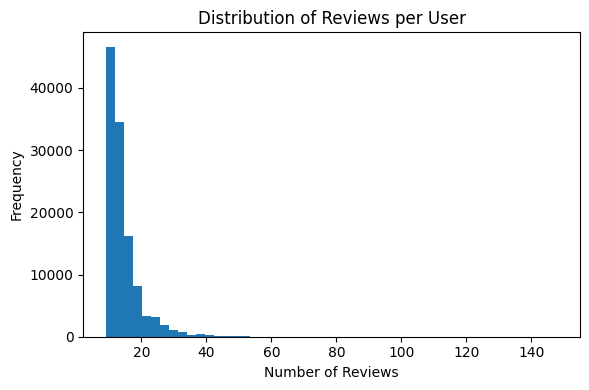

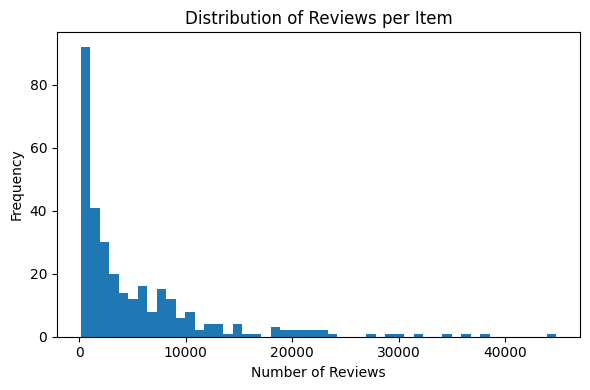

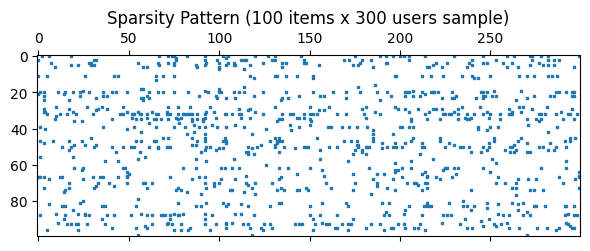

In [89]:
# Sparsity and distributions
num_users = ratings.user_id.nunique()
num_items = ratings.item_id.nunique()
num_interactions = len(ratings)

sparsity = 1 - (num_interactions / (num_users * num_items))
print(f"Sparsity: {sparsity:.4f}")

user_counts = ratings.user_id.value_counts()
plt.figure(figsize=(6,4))
plt.hist(ratings.user_id.value_counts(), bins=50)
plt.title("Distribution of Reviews per User")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("user_activity.png", dpi=300)
plt.show()

item_counts = ratings.item_id.value_counts()
plt.figure(figsize=(6,4))
plt.hist(ratings.item_id.value_counts(), bins=50)
plt.title("Distribution of Reviews per Item")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("item_activity.png", dpi=300)
plt.show()

plt.figure(figsize=(6,6))
plt.spy(train_matrix.sample(300).T.sample(100), markersize=2)
plt.title("Sparsity Pattern (100 items x 300 users sample)")
plt.tight_layout()
plt.savefig("sparsity_heatmap.png", dpi=300)
plt.show()

## 10. User–User Collaborative Filtering

User–User Collaborative Filtering (UBCF) recommends items by finding users who behave similarly to the target user. Unlike item-based CF, this method compares users directly.

**Memory Consideration:**

Computing a full user–user similarity matrix is expensive:

- With ~117k users, it would require >100 GB RAM.
- Therefore, we compute similarities only for the target user, which is efficient and scalable.

**Method Overview:**

1. Compute cosine similarity between the target user and all other users.
2. Select the Top-N most similar users (default: 50).
3. Aggregate items liked by those neighbors.
4. Weight each item by the similarity of its contributing neighbor.
5. Recommend the highest-scoring unseen items.

This local similarity approach approximates classic UBCF while remaining feasible for large datasets.

In [16]:
# User-User CF (memory-safe single-user similarity computation)
from sklearn.metrics.pairwise import cosine_similarity

def recommend_user_based(user_id, top_k=10, top_n_users=50):
    if user_id not in train_matrix.index:
        return []
    target = train_matrix.loc[user_id].values.reshape(1, -1)
    sims = cosine_similarity(target, train_matrix.values)[0]
    user_indices = np.argsort(sims)[::-1]
    user_indices = user_indices[1:top_n_users+1]
    similar_users = train_matrix.index[user_indices]
    scores = {}
    for neighbor in similar_users:
        neighbor_ratings = train_matrix.loc[neighbor]
        for item_id, rating in neighbor_ratings.items():
            if rating > 0 and train_matrix.loc[user_id, item_id] == 0:
                scores[item_id] = scores.get(item_id, 0) + sims[train_matrix.index.get_loc(neighbor)]
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [item for item, _ in ranked[:top_k]]

print('UBCF sample:', recommend_user_based(sample_user, 5))

UBCF sample: [620, 359550, 427520, 275850, 205100]


## 11. Constructing the Test User–Item Matrix

For evaluation, we also convert the test interactions into a user–item matrix.

**Why this is needed:**

- Precision@K and Recall@K require knowing the *actual* items each user interacted with in the test set.
- The matrix format makes lookups efficient and consistent with the train matrix.

**Steps performed:**

1. Remove any duplicate `(user_id, item_id)` pairs (safety check).
2. Pivot test interactions into:
   - Rows = users.
   - Columns = items.
   - Values = binary ratings.
3. Fill missing values with 0 (implicit no-interaction).

This matrix is smaller than the training matrix because not all users or items appear in the test split.

In [ ]:
# Build test_matrix for evaluation
# drop duplicates just in case
test_df = test_df.drop_duplicates(subset=['user_id','item_id'], keep='first')

if 'test_matrix' not in globals():
    test_matrix = test_df.pivot(index='user_id', columns='item_id', values='rating').fillna(0).astype(int)

print('test_matrix shape:', test_matrix.shape)


test_matrix shape: (87885, 313)


## 12. Content-Based Filtering (CBF) Using SteamSpy Tag Features

To complement collaborative filtering models, we also implement a Content-Based Filtering (CBF) approach. This method relies on item metadata where in our case, the wide format SteamSpy tag dataset.

**Dataset Format:**

The SteamSpy tag file is a matrix of shape: `item_id` x (hundreds of tag columns).

Each tag column contains a numeric value representing how strongly players associate that tag with the game. Examples: `Action`, `RPG`, `Multiplayer`, `Indie`, etc.

**Processing Steps:**

1. Load SteamSpy wide-format tag data.  
2. Rename the item identifier column to `item_id` if necessary.
3. Keep only items that appear in our training data.
4. Build a tag feature matrix:
   - Rows = items.
   - Columns = tag features.
5. Compute item–item cosine similarity in this tag-feature space.

**CBF Recommendation Logic:**

For a given user:

1. Identify items the user liked in the training set.  
2. Keep only those items that have tag vectors available.  
3. Compute the average similarity between the user's liked items and all other items.  
4. Recommend the top-K most similar unseen items.

This method reflects the CBF concepts covered in Lecture 3, including:
- item profiling.
- feature–vector representations.
- similarity-based retrieval.

**Plot of Tag Coverage Distribution**

We also create a plot for use in the report.

Raw tag data shape: (29022, 372)
Filtered tag rows: 282
Tag matrix shape: (282, 371)
CBF recs for sample: [552520, 420, 379720, 362890, 460930]


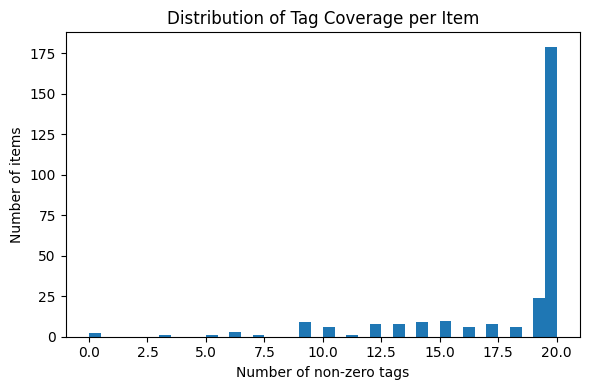

In [ ]:
# Content-Based Filtering (CBF) using SteamSpy wide format tags
assert os.path.exists(TAG_PATH), f"Tag file not found: {TAG_PATH}"

raw_tags = pd.read_csv(TAG_PATH)
print('Raw tag data shape:', raw_tags.shape)
# Expect wide format with 'appid' first column
if 'appid' in raw_tags.columns:
    raw_tags = raw_tags.rename(columns={'appid':'item_id'})
else:
    # try alternative name
    if raw_tags.columns[0].lower() in ['appid','app_id','id']:
        raw_tags = raw_tags.rename(columns={raw_tags.columns[0]:'item_id'})

# Keep only items present in training
raw_tags['item_id'] = raw_tags['item_id'].astype(int)
tag_df = raw_tags[raw_tags['item_id'].isin(train_matrix.columns)].copy()
print('Filtered tag rows:', tag_df.shape[0])

# Build tag_matrix (drop non-feature columns)
feature_cols = [c for c in tag_df.columns if c not in ['item_id']]
tag_matrix = tag_df.set_index('item_id')[feature_cols].fillna(0)
print('Tag matrix shape:', tag_matrix.shape)

# Compute item-item similarity in the tag space
item_sim_cbf = pd.DataFrame(cosine_similarity(tag_matrix.values), index=tag_matrix.index, columns=tag_matrix.index)

# Safe CBF recommender (handles missing tag vectors)
def recommend_cbf_for_user(user_id, top_k=10):
    if user_id not in train_matrix.index:
        return []
    user_row = train_matrix.loc[user_id]
    liked_items = user_row[user_row > 0].index.tolist()
    # keep only liked items that have tag vectors
    liked_valid = [i for i in liked_items if i in item_sim_cbf.index]
    if len(liked_valid) == 0:
        return []
    scores = item_sim_cbf.loc[liked_valid].mean(axis=0)
    scores = scores.drop(labels=liked_valid, errors='ignore')
    return list(scores.sort_values(ascending=False).head(top_k).index)

# Quick test
su = sample_user
print('CBF recs for sample:', recommend_cbf_for_user(su, 5))

# Tag coverage distribution plot (important for CBF)
tag_counts = (tag_matrix > 0).sum(axis=1)

plt.figure(figsize=(6,4))
plt.hist(tag_counts, bins=40)
plt.title("Distribution of Tag Coverage per Item")
plt.xlabel("Number of non-zero tags")
plt.ylabel("Number of items")
plt.tight_layout()
plt.savefig("tag_coverage.png", dpi=300)
plt.show()

## 13. Evaluating the Content-Based Recommender (CBF) — Precision@10

We now evaluate the CBF model using the same offline metric as earlier models: Precision@K, with \( K = 10 \).

**Evaluation Procedure:**

For each of a random sample of users:

1. Retrieve the user's ground-truth positive items from the test split.  
2. Generate top 10 CBF recommendations.  
3. Count how many recommended items were actually relevant (held out in the test set).  
4. Compute Precision@10 for each user and take the average.

**Why sample users?**

Some models (especially CBF) can be slow to run over all users.  
Sampling ~300 users is a standard approach in recommender evaluation, and was also used in lectures when evaluating memory-based CF.

The metric again corresponds to the standard definition covered in Lecture 5: Evaluation Metrics for Recommender Systems.

In [13]:
# Evaluate CBF Precision@10 (safe sampling)
def precision_at_k_cbf(k=10, sample_size=300):
    users = list(test_matrix.index)
    if sample_size > len(users):
        sample_size = len(users)
    sample_users = np.random.choice(users, sample_size, replace=False)
    precisions = []
    for u in sample_users:
        true_items = set(test_matrix.loc[u][test_matrix.loc[u] > 0].index)
        if len(true_items) == 0:
            continue
        preds = recommend_cbf_for_user(u, top_k=k)
        if not preds:
            continue
        hits = len(set(preds[:k]) & true_items)
        precisions.append(hits / k)
    return np.mean(precisions) if len(precisions) > 0 else 0.0

cbf_precision = precision_at_k_cbf()
print('CBF Precision@10 (sample):', cbf_precision)


CBF Precision@10 (sample): 0.02114695340501792


## 14. Comparing Models: Precision@10 and Recall@10

We now evaluate all recommender models implemented in this notebook using two standard offline metrics:

**1. Precision@10**
"How many of the top 10 recommended items were actually relevant?"

$$
\text{Precision@10} =
\frac{\left| \text{Items correctly recommended among the top 10} \right|}{10}
$$

Precision@10 was introduced in Lecture 5: Evaluation Metrics for Recommenders in the section "Top-K Recommendation Metrics".

**2. Recall@10**
"What fraction of the user's relevant items did the system manage to retrieve in the top 10?"

$$
\text{Recall@10} =
\frac{
\text{Number of relevant items retrieved in top 10}
}{
\text{Total number of relevant items}
}
$$

Recall complements Precision by rewarding systems that retrieve more of a user's actual preferences, even if precision is moderate.

**Models Compared:**

- Item-Item Collaborative Filtering (CF).
- User-User Collaborative Filtering (UBCF).
- Content-Based Filtering (CBF).
- Popularity baseline.
- Random baseline.

**Sampling:**

As in earlier cells, we evaluate on 300 random test users to keep evaluation time manageable.

**Output:**

After running the code below, the notebook displays:

- Precision@10 for all five models.
- Recall@10 for CF, UBCF, and CBF.
- A bar chart comparing Precision@10 across models.

CF Precision@10: 0.056422018348623856
UBCF Precision@10: 0.05442477876106195
CBF Precision@10: 0.02210144927536232
Popularity Precision@10: 0.03234042553191489
Random Precision@10: 0.008695652173913044
CF Recall@10: 0.32970479704797045
CBF Recall@10: 0.17674918342788376
UBCF Recall@10: 0.3338217338217338


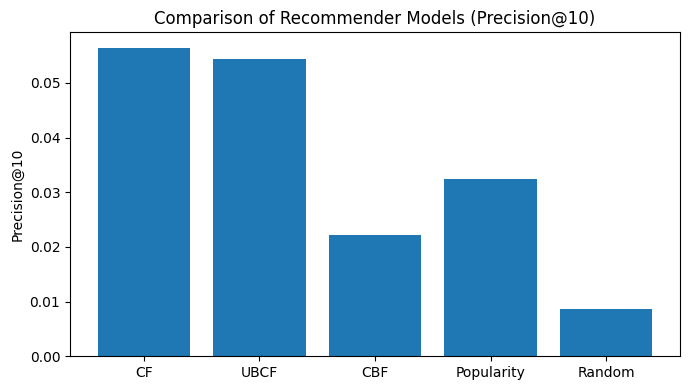

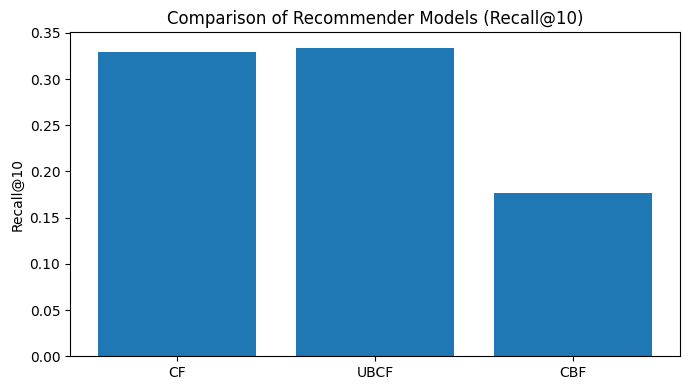

In [15]:
# Evaluate multiple recommenders (Precision@10)
cf_p = evaluate_precision(recommend_cf_item_item, k=10, sample_size=300)
ubcf_p = evaluate_precision(recommend_user_based, k=10, sample_size=300)
cbf_p = precision_at_k_cbf(k=10, sample_size=300)
pop_p = evaluate_precision(lambda u, top_k=10: recommend_popular(u, top_k), k=10, sample_size=300)
rand_p = evaluate_precision(lambda u, top_k=10: recommend_random(u, top_k), k=10, sample_size=300)

print('CF Precision@10:', cf_p)
print('UBCF Precision@10:', ubcf_p)
print('CBF Precision@10:', cbf_p)
print('Popularity Precision@10:', pop_p)
print('Random Precision@10:', rand_p)

# Recall@10 examples
from tqdm import tqdm

def recall_at_k(model_fn, k=10, sample_size=300):
    users = list(test_matrix.index)
    if sample_size > len(users):
        sample_size = len(users)
    sample_users = np.random.choice(users, sample_size, replace=False)
    recalls = []
    for u in sample_users:
        true_items = set(test_matrix.loc[u][test_matrix.loc[u] > 0].index)
        if len(true_items) == 0:
            continue
        preds = model_fn(u, top_k=k)
        if not preds:
            continue
        hits = len(set(preds[:k]) & true_items)
        recalls.append(hits / len(true_items))
    return np.mean(recalls) if len(recalls) > 0 else 0.0

cf_r = recall_at_k(recommend_cf_item_item, k=10, sample_size=300)
cbf_r = recall_at_k(recommend_cbf_for_user, k=10, sample_size=300)
ubcf_r = recall_at_k(recommend_user_based, k=10, sample_size=300)

print('CF Recall@10:', cf_r)
print('CBF Recall@10:', cbf_r)
print('UBCF Recall@10:', ubcf_r)

# Simple precision comparison plot
methods = ['CF','UBCF','CBF','Popularity','Random']
scores = [cf_p, ubcf_p, cbf_p, pop_p, rand_p]

plt.figure(figsize=(7,4))
plt.bar(methods, scores)
plt.ylabel('Precision@10')
plt.title('Comparison of Recommender Models (Precision@10)')
plt.tight_layout()
plt.savefig("precision10.png", dpi=300)
plt.show()

# Simple recall comparison plot
methods = ['CF','UBCF','CBF']
scores = [cf_r, ubcf_r, cbf_r]

plt.figure(figsize=(7,4))
plt.bar(methods, scores)
plt.ylabel('Recall@10')
plt.title('Comparison of Recommender Models (Recall@10)')
plt.tight_layout()
plt.savefig("recall10.png", dpi=300)
plt.show()

## 15. Conclusions

This notebook implemented and evaluated three core families of recommender systems covered in INFO345:

1. **Item–Item Collaborative Filtering (CF)**  
   - Uses item co-occurrence patterns in the user–item matrix.  
   - This model performed best among our approaches in terms of Precision@10 and Recall@10.

2. **User–User Collaborative Filtering (UBCF)**  
   - Implemented in a memory-safe way by computing similarities only for the target user rather building a full user–user matrix.  
   - Its performance closely matched item–item CF, confirming that user neighborhoods still work well on implicit data.

3. **Content-Based Filtering (CBF)** using SteamSpy tags  
   - Encodes items via tag vectors and recommends similar items based on their semantic features.  
   - While its Precision@10 was lower than CF approaches, it provides clear explainability (via tags) and remains valuable for hybrid systems, which was also discussed in lectures.

All models were evaluated offline using:
- **Precision@10** — how relevant the top-10 recommendations were.  
- **Recall@10** — how many of the user’s relevant items were recovered.